In [91]:
from pyrosm import OSM
import geopandas as gpd
import pandas as pd
import networkx as nx
import osmnx as ox
from shapely.geometry import Point
import itertools
import matplotlib.pyplot as plt


data_path = (r'C:\Users\hular\projects\ClosestDestination\testEnvironment\Data')
#Big source: https://sustainability-gis.readthedocs.io/en/latest/lessons/L2/spatial_network_analysis.html

#Clip pbf files using https://wiki.openstreetmap.org/wiki/Osmconvert

In [92]:
homes = gpd.read_file(( 'testEnvironment/Data/pointer_trimmed_for_trimmed_library.shp'))


# # Define the location for OSM
# place = "Belfast, Northern Ireland"
# # Load the street network using osmnx
#     # Set up configuration to use cache and logging
# ox.config(use_cache=True, log_console=True)
# # Include network_type 'drive' if only drivable roads included. e.g. excludes footpaths (excluding service roads)
# roads_graph = ox.graph_from_place(place)



In [93]:
libraries = gpd.read_file('testEnvironment/Data/libraries_belfast_2024_very_trimmed.csv')

In [94]:
libraries.head()

,Static Library Name,Number,Street,Town,Postcode,Tel No,X COORDINATE,Y COORDINATE,geometry
0,Ballyhackamore Library,001-003,Eastleigh Drive,Belfast,BT4 3DX,028 9050 9204,337952,373959,None
1,Finaghy Library,38B,Finaghy Road South,Belfast,BT10 0DR,028 9050 9214,330520,369835,None
2,Grove Library,120,York Road,Belfast,BT15 3HF,028 9050 9244,334106,376724,None
3,Woodstock Library,358,Woodstock Road,Belfast,BT6 9DQ,028 9050 9239,335748,373119,None


c:\Users\hular\anaconda3\envs\netgeo_env\Lib\site-packages\pyrosm\networks.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  edges, nodes = prepare_geodataframe(


<Axes: >

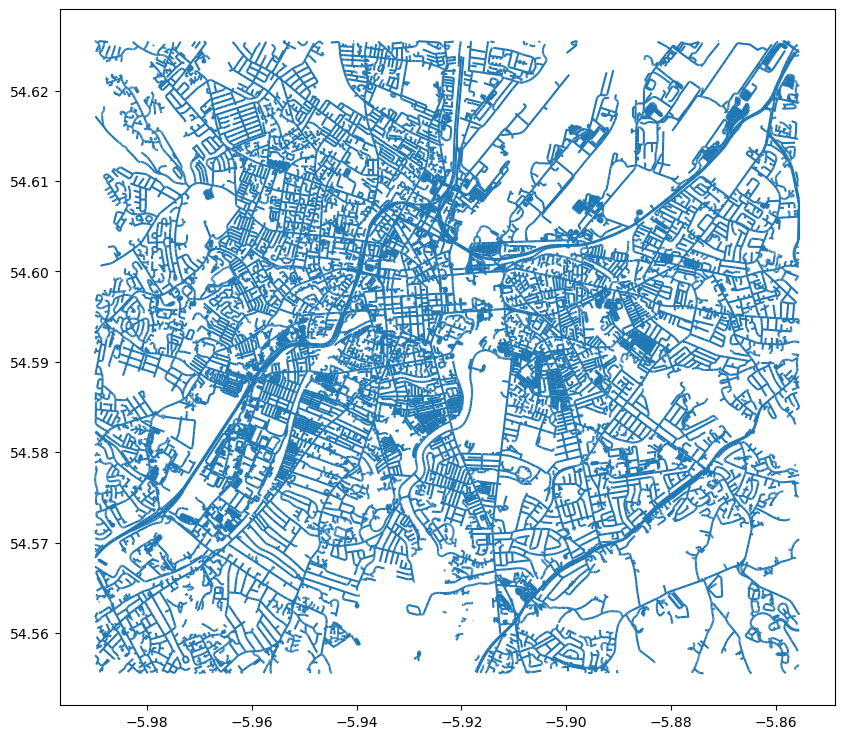

In [95]:
osm = OSM('testEnvironment/Data/belfast_slightly_trimmed.osm.pbf')
roads = osm.get_network(network_type="driving")
roads.plot(figsize=(10,10))

In [96]:
#converts using week 1 example. Use pds apply(Point) to turn into an actual geometry
libraries['geometry'] = list(
    zip(libraries['X COORDINATE'], libraries['Y COORDINATE'])
)

libraries['geometry'] = libraries['geometry'].apply(Point)


# Now check again if any geometry is null
if not libraries['geometry'].isna().any():
    # Delete supurfluous x and y coord columns as now in geometry
    libraries = libraries.drop(columns=['X COORDINATE', 'Y COORDINATE'])

libraries.crs = (29902) #ensure it's the CRS
libraries = libraries.to_crs(epsg=4326)
homes = homes.to_crs(4326)

libraries.head()


C:\Users\hular\AppData\Local\Temp\ipykernel_8636\1434425818.py:2: UserWarning: Geometry column does not contain geometry.
  libraries['geometry'] = list(


,Static Library Name,Number,Street,Town,Postcode,Tel No,geometry
0,Ballyhackamore Library,001-003,Eastleigh Drive,Belfast,BT4 3DX,028 9050 9204,POINT (-5.86641 54.59504)
1,Finaghy Library,38B,Finaghy Road South,Belfast,BT10 0DR,028 9050 9214,POINT (-5.98314 54.55999)
2,Grove Library,120,York Road,Belfast,BT15 3HF,028 9050 9244,POINT (-5.92460 54.62089)
3,Woodstock Library,358,Woodstock Road,Belfast,BT6 9DQ,028 9050 9239,POINT (-5.90087 54.58809)


In [97]:
#Parses nodes and edges for network analysis and plotting.
nodes, edges = osm.get_network(network_type='driving', nodes=True)

In [98]:
# # Replace '60 mph' with 60 in the 'maxspeed' column
# edges['maxspeed'] = edges['maxspeed'].replace('60 mph', 60)


# Function to convert maxspeed strings to integers
def convert_maxspeed(speed):
    """  """
    #if some random numbers or no entry, return the nothing
    if speed is None or speed != speed: 
        return speed
    #if ends with mph, turn into int. Belfast set has this. 
    if speed.endswith('mph'):
        return int(speed.replace('mph', '').strip())
    # eturns the value of speed if it's already a number
    return speed

# Apply the conversion function to the 'maxspeed' column
edges['maxspeed'] = edges['maxspeed'].apply(convert_maxspeed)


In [99]:
#remove non-driving roads/streets
edges = edges.loc[~edges['highway'].isin(['cycleway', 'pedestrian', 'busway', 'trail', 'crossing', 'footway',
                                          'path', 'bridleway', 'trailhead', 'raceway', 'construction'])]
edges['highway'].unique()

array(['residential', 'primary', 'tertiary', 'service', 'primary_link',
       'motorway', 'secondary', 'unclassified', 'trunk', 'motorway_link',
       'trunk_link', 'living_street', 'tertiary_link', 'secondary_link',
       'track'], dtype=object)

In [100]:
# edges.plot()


In [101]:
# assign pandas integer  type so it's in an integer array.

edges['maxspeed'] = edges['maxspeed'].astype(float).astype(pd.Int64Dtype())
edges['maxspeed'].unique()

edges['maxspeed'].isna().sum()


edges.groupby('highway')['maxspeed'].sum()

highway
living_street       2070
motorway           13610
motorway_link       7440
primary            78570
primary_link        6240
residential       299230
secondary          42730
secondary_link      4230
service             9165
tertiary          108540
tertiary_link       5270
track                  0
trunk              46830
trunk_link         14110
unclassified       43650
Name: maxspeed, dtype: Int64

In [102]:
# function to assign empty maxspeed to blanket values. To be modified with more clarity

def road_class_to_mph(road_class):
    """ Assigns mph integer speeds to the dataset, use this function with .apply() on appropriate column"""
    if road_class == 'motorway':   
        return 70
    elif road_class in ['primary', 'trunk']:
        return 60
    elif road_class in ['motorway_link', 'primary_link', 'secondary', 'trunk_link', 'unclassified']:
        return 50
    elif road_class in ['residential', 'secondary_link', 'service', 'tertiary', 'tertiary_link', 'track']:
        return 30
    elif road_class in ['living_street', 'tertiary_link']:
        return 20
    elif road_class == 'services':
        return 10
    elif road_class == 'rest_area':
        return 5
    

In [103]:
#separates layers with and without speed limit information for use with road_class_to_mph function
mask = edges['maxspeed'].isnull()
edges_without_maxspeed = edges.loc[mask].copy()
edges_with_maxspeed = edges.loc[~mask].copy()

edges_without_maxspeed['maxspeed'] = edges_without_maxspeed['highway'].apply(road_class_to_mph)
edges_without_maxspeed['maxspeed'].unique()


array([30, 50, 60, 20], dtype=int64)

In [104]:
# Append modified without_speed back to unmasked max speed edges
edges = pd.concat([edges_with_maxspeed, edges_without_maxspeed], ignore_index=True)
edges['maxspeed'].unique()

<IntegerArray>
[30, 50, 20, 40, 60, 70, 15, 10]
Length: 8, dtype: Int64

In [105]:
#for plotting, make maxspeed back into regular integer series, we had it changed to integer array.
edges['maxspeed'] = edges['maxspeed'].astype(int)
# ax = edges.plot(column = 'maxspeed', figsize=(10,10), legend=True)

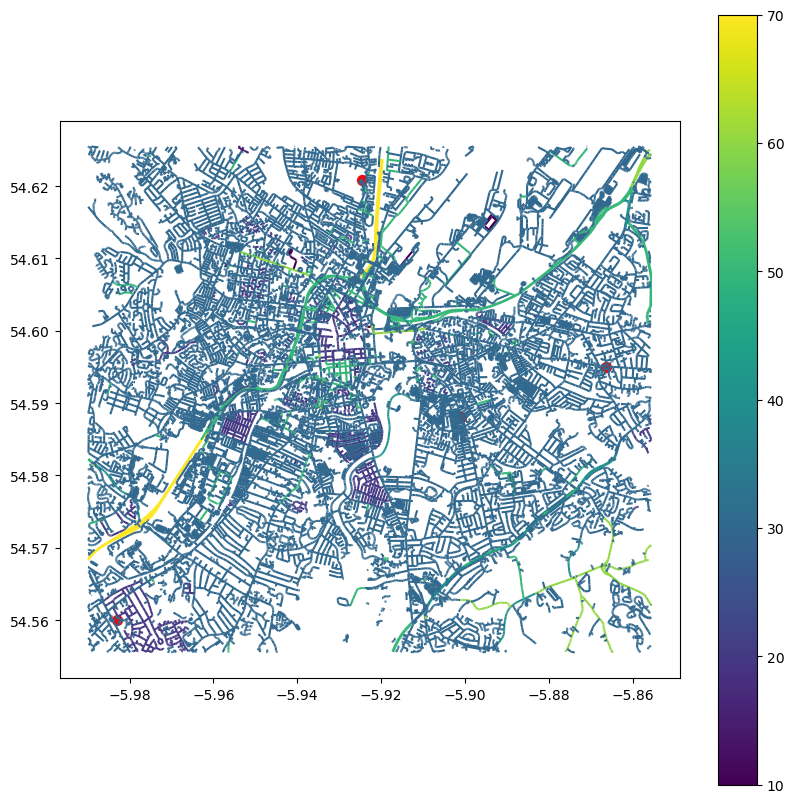

In [106]:
fig, ax = plt.subplots(figsize=(10, 10))
libraries.plot(ax=ax, marker='o', color='red', markersize=50)
edges.plot(ax=ax, column='maxspeed', figsize=(10, 10), legend=True) 

plt.show()


In [107]:
#converts mph using metres as length into travel time in seconds
edges['travel_time_seconds'] = edges['length'] / (edges['maxspeed']*1609) *60 

In [108]:
# # Uncomment to show interactive graph using folium. FOlium is apparently being deprecated, use geopandas./
g = osm.to_graph(nodes, edges, graph_type='networkx')
# ox.plot_graph_folium(g)


In [109]:
def house_to_closest(start_locations, destination_locations, networkx_graph=g, buffer_distance = 4000):
    """ Shortest distance to destination function. Iterates over each destination for each input location.
    Uses dijkstra's algorithm to iterate.
    
    Args:
        beginning_dataset (str): Start location dataset with geometry
        destination_dataset (str): Destination dataset with geometry
        network_x_graph (str): graph created using networkx {default: g}
    """
    #Preload the nearest nodes to destination to reduce insane run times
    # Create a dict of destination ids to iterate over with houses.
    dest_node_ids = {}

    for index, row in destination_locations.iterrows():
        dest_x = row['geometry'].x
        dest_y = row['geometry'].y
        dest_node_ids[index] = ox.distance.nearest_nodes(networkx_graph, dest_x, dest_y)
        
    start_location['buffer'] = start_locations['geometry'].buffer(buffer_distance)
        
    #iterate over each house, then library.
    for index, row in start_locations.iterrows():
        start_locations_buffer = start['buffer']
        orig_x = row['geometry'].x
        orig_y = row['geometry'].y       
        orig_node_id = ox.distance.nearest_nodes(networkx_graph, X = orig_x, Y = orig_y)
        
        local_destinations = destination_locations[destination_locations['geometry'].within(start_locations_buffer)]

        # iterate over destination node id dictionary for shortest distance out of all desitnations
        # Can enhance this by putting a buffer around each house to select for 3 or so destionations    
        shortest_distance = float('inf')

        for dest_index, dest_node_id in dest_node_ids.items():
            path_length = nx.shortest_path_length(networkx_graph, source=orig_node_id, target = dest_node_id,
                                                  weight = 'length')
            if path_length < shortest_distance:
                shortest_distance = path_length
         
        # Update the shortest distance in the DataFrame
        start_locations.at[index, 'shortest_dist_to_dest'] = shortest_distance
        
house_to_closest(homes, libraries, g)
        

KeyboardInterrupt: 

In [ ]:
homes.head(25)

,uuid_10_Fi,X_COR,Y_COR,geometry,shortest_dist_to_dest
0,7140891c47,332207,374220,POINT (-5.95511 54.59892),3936.163
1,77671aee96,332207,374220,POINT (-5.95511 54.59892),3936.163
2,99baca8892,333535,374236,POINT (-5.93457 54.59871),2736.765
3,c564aaf847,331719,374081,POINT (-5.96271 54.59780),4598.718
4,070b3e0714,331782,374032,POINT (-5.96176 54.59734),4535.688
5,d57f98da00,331771,374168,POINT (-5.96187 54.59856),4580.228
6,4da16d5cd0,332400,374077,POINT (-5.95219 54.59758),3767.612
7,0634d60fdf,332937,374190,POINT (-5.94383 54.59846),3353.987
8,0017e4aff4,333346,374243,POINT (-5.93748 54.59882),3274.062
9,ce689b9936,332759,373758,POINT (-5.94678 54.59462),3869.210


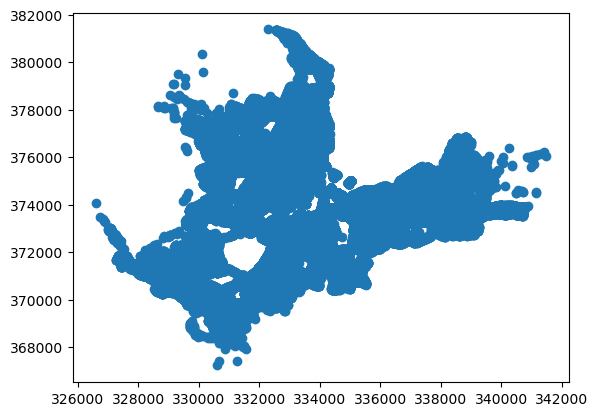

In [ ]:
plt.scatter(homes['geometry'].x, homes['geometry'].y)

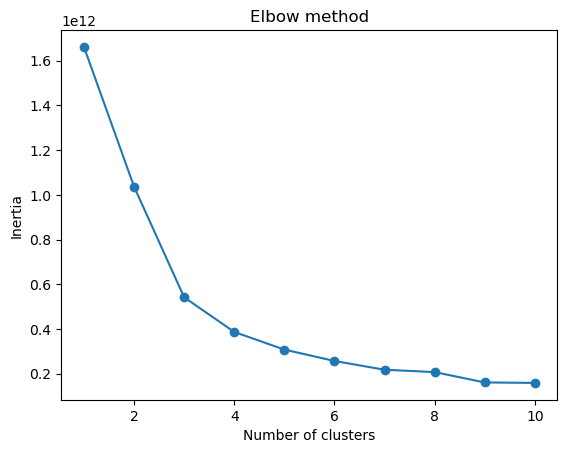

In [ ]:
from sklearn.cluster import KMeans
data = list(zip(homes['geometry'].x, homes['geometry'].y))
inertias = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)
    
plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

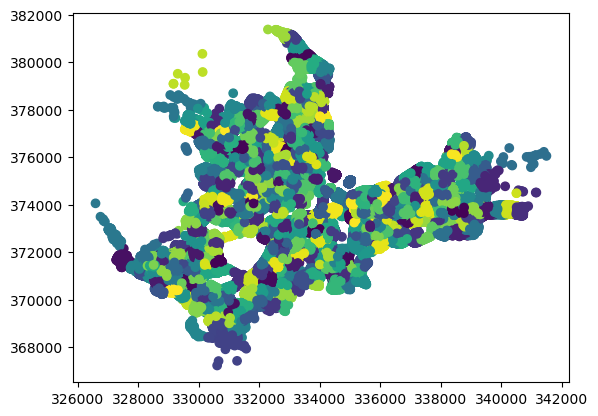

KMeans(n_clusters=400)


In [ ]:
# pick k value where there is elbow, buyt this is spatial data.
# high k values like 400 seem better. Need to investigate better clustering.

kmeans = KMeans(n_clusters=4)
kmeans_fitted = kmeans.fit(data)

plt.scatter(homes['geometry'].x, homes['geometry'].y, c = kmeans.labels_)
plt.show()

print(kmeans_fitted)